In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [3]:
train_dataset = torchvision.datasets.FashionMNIST("./chap05/data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('./chap05/data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

C:\Users\bokdo\.conda\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

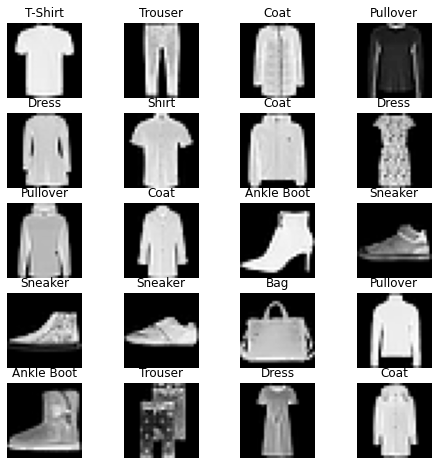

In [5]:
labels_map = {0: 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows + 1):
  img_xy = np.random.randint(len(train_dataset))
  img = train_dataset[img_xy][0][0, :, :]
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show()

In [6]:
class FashionDNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data):
    out = input_data.view(-1, 784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)

    return out

In [7]:
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
num_epochs = 10
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for i, epoch in enumerate(range(num_epochs)):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 100):
      print(f'Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}%')

Iteration: 100, Loss: 0.6180905699729919, Accuracy: 75.58999633789062%
Iteration: 200, Loss: 0.6477658748626709, Accuracy: 81.1500015258789%
Iteration: 300, Loss: 0.4697495996952057, Accuracy: 80.52999877929688%
Iteration: 400, Loss: 0.5323518514633179, Accuracy: 82.43999481201172%
Iteration: 500, Loss: 0.6053248047828674, Accuracy: 83.45999908447266%
Iteration: 600, Loss: 0.39391109347343445, Accuracy: 83.80999755859375%
Iteration: 700, Loss: 0.40704479813575745, Accuracy: 83.93999481201172%
Iteration: 800, Loss: 0.4249389171600342, Accuracy: 84.31999969482422%
Iteration: 900, Loss: 0.3920057415962219, Accuracy: 82.90999603271484%
Iteration: 1000, Loss: 0.44139957427978516, Accuracy: 84.56999969482422%
Iteration: 1100, Loss: 0.5202935338020325, Accuracy: 84.68999481201172%
Iteration: 1200, Loss: 0.3410525918006897, Accuracy: 85.19999694824219%
Iteration: 1300, Loss: 0.3479379713535309, Accuracy: 85.50999450683594%
Iteration: 1400, Loss: 0.39604881405830383, Accuracy: 84.83999633789062

In [14]:
class FashionCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [15]:
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [16]:
num_epochs = 10
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for i, epoch in enumerate(range(num_epochs)):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data.cpu())
      iteration_list.append(count)
      accuracy_list.append((accuracy/100).cpu())

    if not (count % 100):
      print(f'Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}%')

Iteration: 100, Loss: 0.5016728043556213, Accuracy: 84.0%
Iteration: 200, Loss: 0.43518802523612976, Accuracy: 85.12999725341797%
Iteration: 300, Loss: 0.32627660036087036, Accuracy: 86.36000061035156%
Iteration: 400, Loss: 0.46064403653144836, Accuracy: 84.79999542236328%
Iteration: 500, Loss: 0.4514884650707245, Accuracy: 87.12999725341797%
Iteration: 600, Loss: 0.28625425696372986, Accuracy: 87.04000091552734%
Iteration: 700, Loss: 0.24475254118442535, Accuracy: 88.38999938964844%
Iteration: 800, Loss: 0.3988514840602875, Accuracy: 87.52999877929688%
Iteration: 900, Loss: 0.3454378843307495, Accuracy: 87.6199951171875%
Iteration: 1000, Loss: 0.38498568534851074, Accuracy: 88.02999877929688%
Iteration: 1100, Loss: 0.3331928253173828, Accuracy: 89.68000030517578%
Iteration: 1200, Loss: 0.2619418799877167, Accuracy: 86.98999786376953%
Iteration: 1300, Loss: 0.193069726228714, Accuracy: 89.93000030517578%
Iteration: 1400, Loss: 0.2354050576686859, Accuracy: 88.87999725341797%
Iteration:

[tensor(0.8012), tensor(0.8400), tensor(0.8354), tensor(0.8513), tensor(0.8551), tensor(0.8636), tensor(0.8739), tensor(0.8480), tensor(0.8582), tensor(0.8713), tensor(0.8860), tensor(0.8704), tensor(0.8842), tensor(0.8839), tensor(0.8801), tensor(0.8753), tensor(0.8863), tensor(0.8762), tensor(0.8653), tensor(0.8803), tensor(0.8648), tensor(0.8968), tensor(0.8899), tensor(0.8699), tensor(0.8920), tensor(0.8993), tensor(0.8763), tensor(0.8888), tensor(0.8872), tensor(0.8830), tensor(0.8877), tensor(0.9012), tensor(0.8787), tensor(0.8994), tensor(0.8925), tensor(0.8860), tensor(0.9019), tensor(0.8983), tensor(0.8929), tensor(0.8911), tensor(0.8859), tensor(0.8813), tensor(0.8940), tensor(0.9010), tensor(0.8952), tensor(0.9082), tensor(0.8914), tensor(0.9061), tensor(0.9069), tensor(0.8985), tensor(0.8988), tensor(0.8955), tensor(0.8892), tensor(0.8898), tensor(0.9008), tensor(0.9053), tensor(0.9016), tensor(0.9069), tensor(0.8978), tensor(0.9033), tensor(0.9072), tensor(0.9014), tensor(

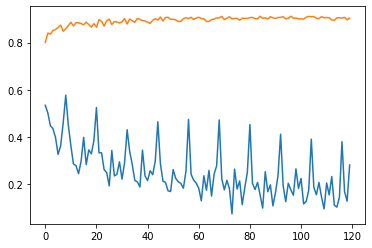

In [17]:
plt.plot(loss_list)
plt.plot(accuracy_list)
plt.show()